<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/utsml__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Pipeline End-to-End untuk Klasifikasi Machine Learning
Notebook ini mendemonstrasikan pipeline lengkap untuk klasifikasi machine learning mengikuti langkah-langkah yang diperlukan:

1. Pengumpulan dan pembersihan data
2. Feature selection menggunakan berbagai teknik
3. Feature engineering
Pelatihan model dan evaluasi menggunakan berbagai metrik

Mari kita mulai dengan mengimpor semua library yang diperlukan.

In [5]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import time
import warnings
warnings.filterwarnings('ignore')

# Untuk preprocessing dan feature selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.decomposition import PCA

# Untuk pembuatan model dan evaluasi
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, BaggingClassifier
)
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc,
    roc_auc_score
)

# Mengatur gaya plot
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_palette("viridis")

## 1. Pengumpulan dan Pembersihan Data

Pada langkah ini, kita akan memuat dataset, mengeksplorasi karakteristiknya, dan membersihkannya dengan menangani nilai yang hilang, duplikat, dan outlier.

In [6]:
# Memuat dataset
print("="*80)
print("LANGKAH 1: PENGUMPULAN DAN PEMBERSIHAN DATA")
print("="*80)

# Untuk contoh ini, kita akan menggunakan dataset sampel
# Ganti dengan path file Anda sendiri
file_path = 'KlasifikasiUTS.csv'

# Memuat data
try:
    df = pd.read_csv(file_path)

    # Menampilkan informasi dasar
    print(f"\nUkuran dataset: {df.shape}")
    print("\n5 baris pertama:")
    print(df.head())

    print("\nTipe data:")
    print(df.dtypes)

    print("\nStatistik ringkasan:")
    print(df.describe())

    # Memeriksa nilai yang hilang
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100

    missing_df = pd.DataFrame({
        'Nilai Hilang': missing_values,
        'Persentase': missing_percentage
    })

    print("\nAnalisis nilai hilang:")
    print(missing_df[missing_df['Nilai Hilang'] > 0])

    # Memeriksa duplikat
    duplicate_count = df.duplicated().sum()
    print(f"\nJumlah baris duplikat: {duplicate_count} ({duplicate_count/len(df):.2%} dari data)")

except FileNotFoundError:
    print(f"File tidak ditemukan: {file_path}")
    # Membuat dataset dummy jika file tidak ditemukan
    print("Membuat dataset dummy untuk demonstrasi...")

    # Anda bisa mengganti ini dengan dataset Anda sendiri
    from sklearn.datasets import load_breast_cancer
    data = load_breast_cancer()
    df = pd.DataFrame(data.data, columns=data.feature_names)
    df['target'] = data.target

    print(f"\nUkuran dataset dummy: {df.shape}")
    print("\n5 baris pertama:")
    print(df.head())

LANGKAH 1: PENGUMPULAN DAN PEMBERSIHAN DATA
File tidak ditemukan: KlasifikasiUTS.csv
Membuat dataset dummy untuk demonstrasi...

Ukuran dataset dummy: (569, 31)

5 baris pertama:
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520        

### Penanganan Nilai yang Hilang dan Outlier

Setelah memeriksa dataset, kita perlu menangani masalah-masalah yang ditemukan. Kita akan mengidentifikasi fitur numerik dan kategorikal, menangani nilai yang hilang menggunakan teknik imputasi, dan mengatasi outlier dengan metode IQR.

In [7]:
# Mengidentifikasi kolom target (biasanya kolom terakhir)
target_col = df.columns[-1]
print(f"\nKolom target: '{target_col}'")

# Memisahkan fitur dan target
X = df.drop(columns=[target_col])
y = df[target_col]

# Mengidentifikasi tipe fitur
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

print(f"\nFitur numerik: {len(numeric_features)}")
print(f"Fitur kategorikal: {len(categorical_features)}")

# Menangani nilai yang hilang
print("\n" + "-"*50)
print("Menangani Nilai yang Hilang")
print("-"*50)

# Menangani nilai numerik yang hilang dengan median
if len(numeric_features) > 0:
    numeric_imputer = SimpleImputer(strategy='median')
    X[numeric_features] = numeric_imputer.fit_transform(X[numeric_features])

# Menangani nilai kategorikal yang hilang dengan modus
if len(categorical_features) > 0:
    categorical_imputer = SimpleImputer(strategy='most_frequent')
    X[categorical_features] = categorical_imputer.fit_transform(X[categorical_features])

print(f"Nilai yang hilang setelah imputasi: {X.isnull().sum().sum()}")

# Menangani outlier untuk fitur numerik menggunakan metode IQR
print("\n" + "-"*50)
print("Menangani Outlier")
print("-"*50)

for col in numeric_features:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Menghitung outlier
    outliers = ((X[col] < lower_bound) | (X[col] > upper_bound)).sum()
    if outliers > 0:
        print(f"Kolom '{col}' memiliki {outliers} outlier ({outliers/len(X):.2%})")

        # Mengganti outlier dengan batas
        X[col] = np.where(X[col] < lower_bound, lower_bound, X[col])
        X[col] = np.where(X[col] > upper_bound, upper_bound, X[col])

# Menghapus duplikat
print("\n" + "-"*50)
print("Menghapus Duplikat")
print("-"*50)

duplicates = X.duplicated().sum()
if duplicates > 0:
    X = X.loc[~X.duplicated()]
    y = y.loc[X.index]
    print(f"Menghapus {duplicates} baris duplikat")
else:
    print("Tidak ada baris duplikat")

# Encoding target jika kategorikal
if y.dtype == 'object':
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    class_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}
    print("\nPemetaan encoding target:")
    for encoded, original in class_mapping.items():
        print(f"  {encoded} -> {original}")

print(f"\nUkuran data final setelah pembersihan: X: {X.shape}, y: {y.shape}")


Kolom target: 'target'

Fitur numerik: 30
Fitur kategorikal: 0

--------------------------------------------------
Menangani Nilai yang Hilang
--------------------------------------------------
Nilai yang hilang setelah imputasi: 0

--------------------------------------------------
Menangani Outlier
--------------------------------------------------
Kolom 'mean radius' memiliki 14 outlier (2.46%)
Kolom 'mean texture' memiliki 7 outlier (1.23%)
Kolom 'mean perimeter' memiliki 13 outlier (2.28%)
Kolom 'mean area' memiliki 25 outlier (4.39%)
Kolom 'mean smoothness' memiliki 6 outlier (1.05%)
Kolom 'mean compactness' memiliki 16 outlier (2.81%)
Kolom 'mean concavity' memiliki 18 outlier (3.16%)
Kolom 'mean concave points' memiliki 10 outlier (1.76%)
Kolom 'mean symmetry' memiliki 15 outlier (2.64%)
Kolom 'mean fractal dimension' memiliki 15 outlier (2.64%)
Kolom 'radius error' memiliki 38 outlier (6.68%)
Kolom 'texture error' memiliki 20 outlier (3.51%)
Kolom 'perimeter error' memiliki 3

## 2. Feature Selection

Feature selection adalah proses memilih fitur yang paling relevan untuk model kita. Kita akan menggunakan berbagai teknik termasuk menghapus fitur konstan/quasi-konstan, mendeteksi fitur duplikat, dan analisis korelasi.

In [8]:
print("\n" + "="*80)
print("LANGKAH 2: FEATURE SELECTION")
print("="*80)

# A. Menghapus fitur konstan dan quasi-konstan
print("\n" + "-"*50)
print("A. Mengidentifikasi Fitur Konstan dan Quasi-Konstan")
print("-"*50)

if len(numeric_features) > 0:
    variance_selector = VarianceThreshold(threshold=0.01)
    try:
        # Menerapkan threshold variansi hanya untuk fitur numerik
        variance_selector.fit(X[numeric_features])

        # Mendapatkan mask fitur yang akan dipertahankan
        low_var_features = [feature for feature, keep in zip(
            numeric_features, variance_selector.get_support()) if not keep]

        if low_var_features:
            print(f"Fitur dengan variansi rendah yang akan dihapus: {low_var_features}")
            X = X.drop(columns=low_var_features)
        else:
            print("Tidak ditemukan fitur konstan atau quasi-konstan.")
    except Exception as e:
        print(f"Error dalam seleksi threshold variansi: {e}")
else:
    print("Tidak ada fitur numerik untuk seleksi threshold variansi.")

# B. Mengidentifikasi fitur duplikat
print("\n" + "-"*50)
print("B. Mengidentifikasi Fitur Duplikat")
print("-"*50)

numeric_features_after_variance = [col for col in numeric_features if col in X.columns]
duplicate_features = []

if len(numeric_features_after_variance) > 1:
    for i in range(len(numeric_features_after_variance)):
        for j in range(i+1, len(numeric_features_after_variance)):
            col1 = numeric_features_after_variance[i]
            col2 = numeric_features_after_variance[j]
            if X[col1].equals(X[col2]):
                duplicate_features.append(col2)

    if duplicate_features:
        print(f"Fitur duplikat yang akan dihapus: {duplicate_features}")
        X = X.drop(columns=duplicate_features)
    else:
        print("Tidak ditemukan fitur duplikat.")
else:
    print("Tidak cukup fitur numerik untuk memeriksa duplikat.")


LANGKAH 2: FEATURE SELECTION

--------------------------------------------------
A. Mengidentifikasi Fitur Konstan dan Quasi-Konstan
--------------------------------------------------
Fitur dengan variansi rendah yang akan dihapus: ['mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst smoothness', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

--------------------------------------------------
B. Mengidentifikasi Fitur Duplikat
--------------------------------------------------
Tidak ditemukan fitur duplikat.


### Analisis Korelasi dan Mutual Information

Selanjutnya, kita akan melakukan analisis korelasi dan mutual information untuk mengidentifikasi hubungan antar fitur dan dengan target.


--------------------------------------------------
C. Analisis Korelasi
--------------------------------------------------


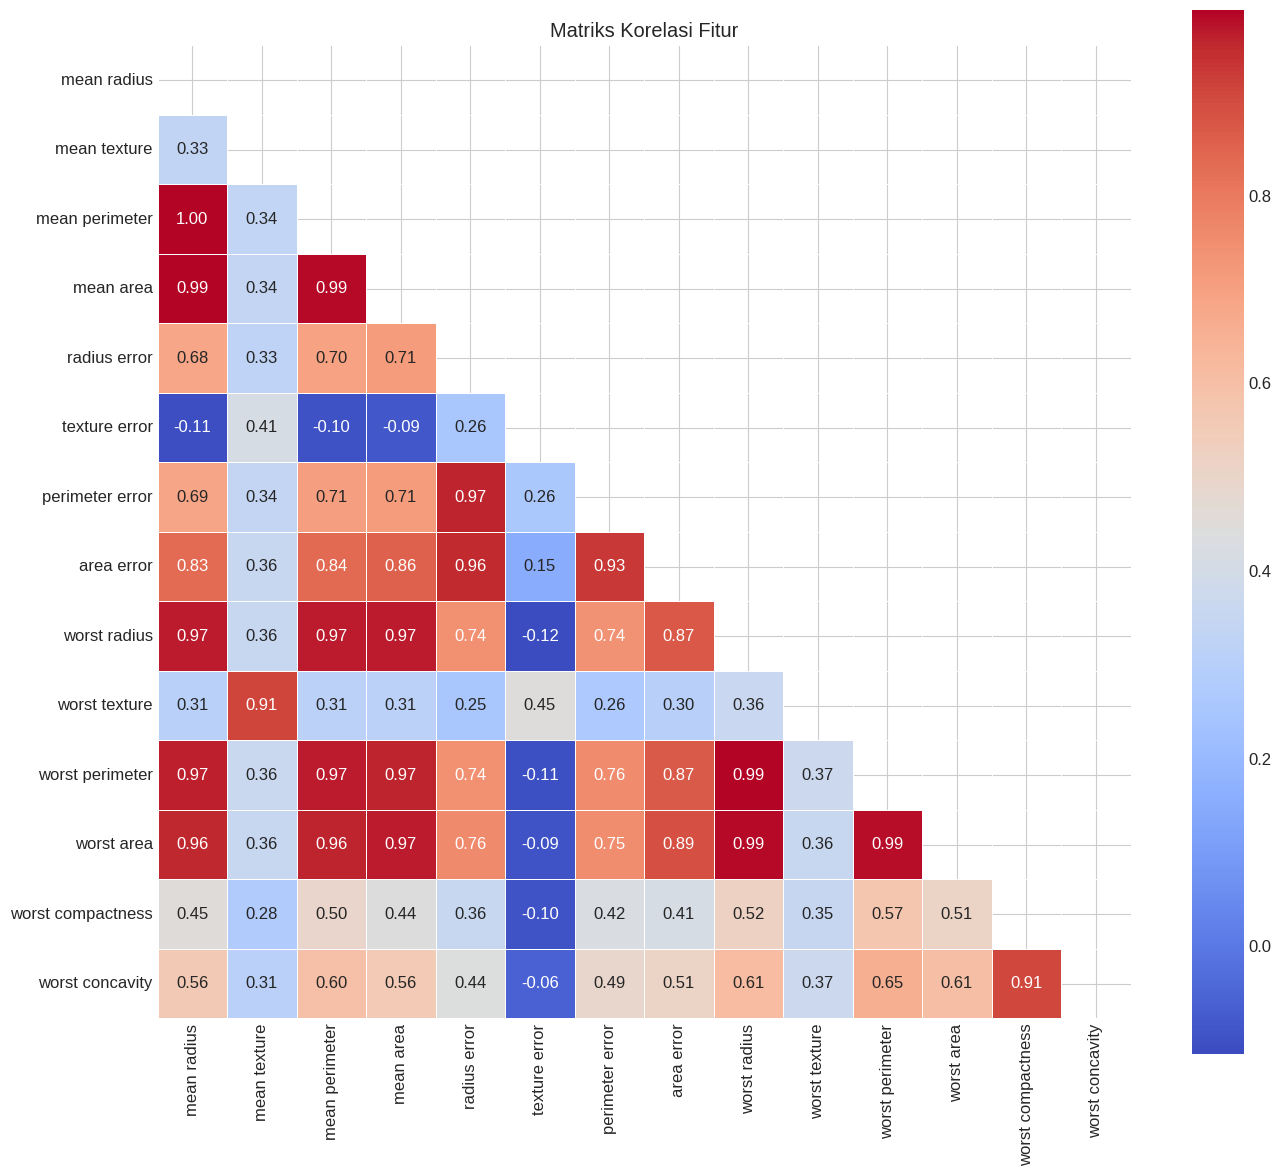


Fitur dengan korelasi tinggi (>0.8):
  mean perimeter dan mean radius: 0.9977
  mean area dan mean radius: 0.9939
  mean area dan mean perimeter: 0.9919
  perimeter error dan radius error: 0.9672
  area error dan mean radius: 0.8327
  area error dan mean perimeter: 0.8408
  area error dan mean area: 0.8572
  area error dan radius error: 0.9573
  area error dan perimeter error: 0.9341
  worst radius dan mean radius: 0.9735
  worst radius dan mean perimeter: 0.9746
  worst radius dan mean area: 0.9738
  worst radius dan area error: 0.8737
  worst texture dan mean texture: 0.9116
  worst perimeter dan mean radius: 0.9675
  worst perimeter dan mean perimeter: 0.9739
  worst perimeter dan mean area: 0.9672
  worst perimeter dan area error: 0.8692
  worst perimeter dan worst radius: 0.9937
  worst area dan mean radius: 0.9625
  worst area dan mean perimeter: 0.9639
  worst area dan mean area: 0.9735
  worst area dan area error: 0.8917
  worst area dan worst radius: 0.9932
  worst area dan w

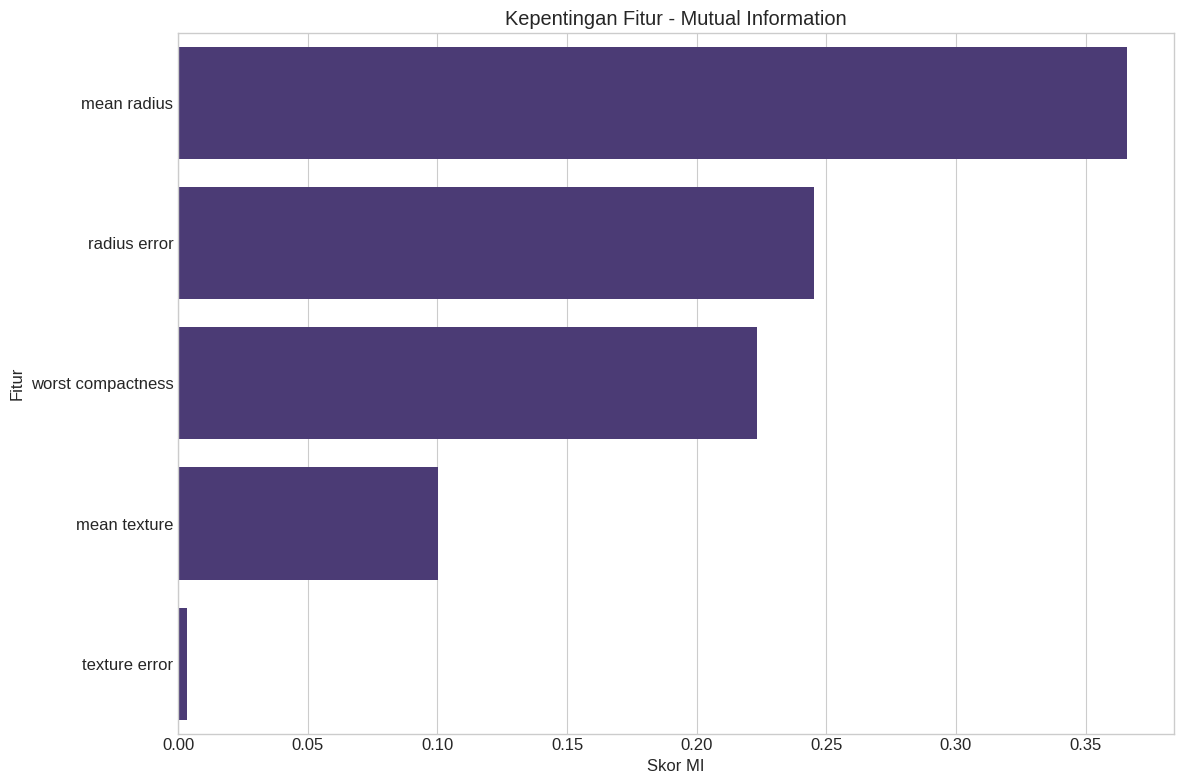


Fitur dengan mutual information rendah (<0.01):
['texture error']


In [9]:
# C. Analisis korelasi
print("\n" + "-"*50)
print("C. Analisis Korelasi")
print("-"*50)

numeric_features_current = X.select_dtypes(include=['int64', 'float64']).columns

if len(numeric_features_current) > 1:
    correlation_matrix = X[numeric_features_current].corr()

    # Plot matriks korelasi
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(correlation_matrix))
    sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='coolwarm',
               fmt='.2f', square=True, linewidths=0.5)
    plt.title('Matriks Korelasi Fitur')
    plt.tight_layout()
    plt.show()

    # Mengidentifikasi fitur dengan korelasi tinggi
    high_corr_threshold = 0.8
    high_corr_features = []

    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
                feature = correlation_matrix.columns[i]
                correlated_with = correlation_matrix.columns[j]
                high_corr_features.append((feature, correlated_with, correlation_matrix.iloc[i, j]))

    if high_corr_features:
        print(f"\nFitur dengan korelasi tinggi (>{high_corr_threshold}):")
        for feat1, feat2, corr in high_corr_features:
            print(f"  {feat1} dan {feat2}: {corr:.4f}")

        # Memilih satu fitur dari setiap pasangan berkorelasi tinggi untuk dihapus
        to_drop = set()
        for feat1, feat2, _ in high_corr_features:
            # Mempertahankan fitur pertama dari setiap pasangan, menghapus yang kedua
            to_drop.add(feat1)

        if to_drop:
            print(f"\nMenghapus fitur berkorelasi tinggi ini: {list(to_drop)}")
            X = X.drop(columns=list(to_drop))
    else:
        print("Tidak ditemukan fitur dengan korelasi tinggi.")
else:
    print("Tidak cukup fitur numerik untuk analisis korelasi.")

# D. Analisis Mutual Information
print("\n" + "-"*50)
print("D. Analisis Mutual Information")
print("-"*50)

current_numeric = X.select_dtypes(include=['int64', 'float64']).columns

if len(current_numeric) > 0:
    try:
        # Menangani nilai NaN
        X_mi = X[current_numeric].fillna(0)

        # Menghitung skor mutual information
        mi_scores = mutual_info_classif(X_mi, y, random_state=42)
        mi_results = pd.DataFrame({
            'Fitur': current_numeric,
            'Skor MI': mi_scores
        }).sort_values('Skor MI', ascending=False)

        print("\nSkor Mutual Information:")
        print(mi_results)

        # Visualisasi skor mutual information
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Skor MI', y='Fitur', data=mi_results)
        plt.title('Kepentingan Fitur - Mutual Information')
        plt.tight_layout()
        plt.show()

        # Memilih fitur teratas berdasarkan skor MI
        mi_threshold = 0.01  # Sesuaikan threshold sesuai kebutuhan
        low_mi_features = mi_results[mi_results['Skor MI'] < mi_threshold]['Fitur'].tolist()

        if low_mi_features:
            print(f"\nFitur dengan mutual information rendah (<{mi_threshold}):")
            print(low_mi_features)
            # Kita akan mempertahankan fitur ini untuk saat ini, tetapi mencatat kepentingan rendah mereka

    except Exception as e:
        print(f"Error dalam analisis mutual information: {e}")
else:
    print("Tidak ada fitur numerik untuk analisis mutual information.")

### Chi-Square Test dan ANOVA F-test

Sekarang kita akan melakukan pengujian Chi-Square dan ANOVA F-test untuk seleksi fitur tambahan.


--------------------------------------------------
E. Uji Chi-Square untuk Fitur Kategorikal
--------------------------------------------------
Tidak ada fitur kategorikal untuk uji chi-square.

--------------------------------------------------
F. Uji ANOVA F-test untuk Fitur Numerik
--------------------------------------------------

Hasil Uji ANOVA F-test:
               Fitur  Skor ANOVA
0        mean radius  708.155869
2       radius error  398.395472
4  worst compactness  337.915688
1       mean texture  120.826150
3      texture error    0.000013


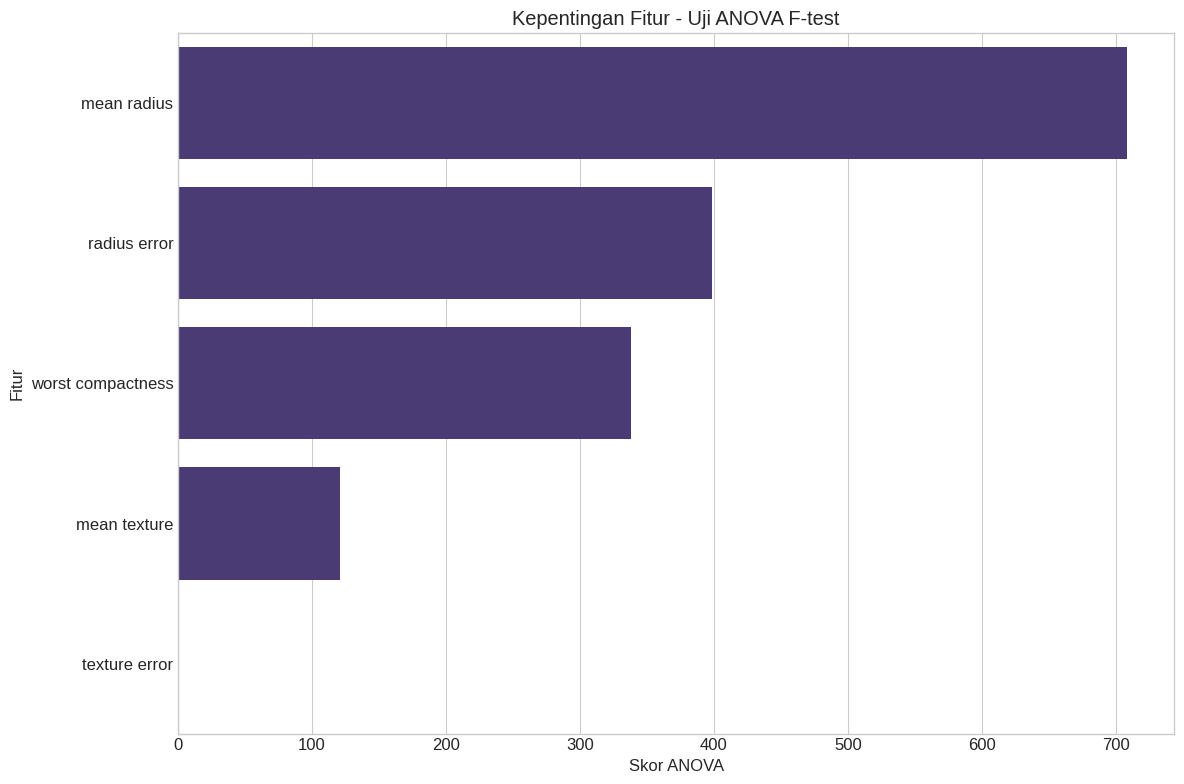


Fitur setelah seleksi: 5 (dari asli 30)
Fitur yang dipilih: ['mean radius', 'mean texture', 'radius error', 'texture error', 'worst compactness']


In [10]:
# E. Uji Chi-Square (untuk fitur kategorikal)
print("\n" + "-"*50)
print("E. Uji Chi-Square untuk Fitur Kategorikal")
print("-"*50)

current_categorical = [col for col in categorical_features if col in X.columns]

if len(current_categorical) > 0:
    # Encoding fitur kategorikal
    X_encoded = pd.get_dummies(X[current_categorical], drop_first=True)

    if X_encoded.shape[1] > 0:
        try:
            # Menerapkan uji chi-square
            chi2_selector = SelectKBest(chi2, k='all')
            chi2_selector.fit(X_encoded, y)

            chi2_results = pd.DataFrame({
                'Fitur': X_encoded.columns,
                'Skor Chi2': chi2_selector.scores_
            }).sort_values('Skor Chi2', ascending=False)

            print("\nHasil Uji Chi-Square:")
            print(chi2_results)

            # Visualisasi skor chi-square
            plt.figure(figsize=(12, 8))
            sns.barplot(x='Skor Chi2', y='Fitur', data=chi2_results)
            plt.title('Kepentingan Fitur - Uji Chi-Square')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Error dalam uji chi-square: {e}")
    else:
        print("Tidak ada fitur yang tersedia setelah one-hot encoding.")
else:
    print("Tidak ada fitur kategorikal untuk uji chi-square.")

# F. Uji ANOVA F-test (untuk fitur numerik)
print("\n" + "-"*50)
print("F. Uji ANOVA F-test untuk Fitur Numerik")
print("-"*50)

current_numeric = X.select_dtypes(include=['int64', 'float64']).columns

if len(current_numeric) > 0:
    try:
        # Menangani nilai NaN
        X_anova = X[current_numeric].fillna(0)

        # Menerapkan uji ANOVA F-test
        anova_selector = SelectKBest(f_classif, k='all')
        anova_selector.fit(X_anova, y)

        anova_results = pd.DataFrame({
            'Fitur': current_numeric,
            'Skor ANOVA': anova_selector.scores_
        }).sort_values('Skor ANOVA', ascending=False)

        print("\nHasil Uji ANOVA F-test:")
        print(anova_results)

        # Visualisasi skor ANOVA
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Skor ANOVA', y='Fitur', data=anova_results)
        plt.title('Kepentingan Fitur - Uji ANOVA F-test')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error dalam uji ANOVA F-test: {e}")
else:
    print("Tidak ada fitur numerik untuk uji ANOVA F-test.")

print(f"\nFitur setelah seleksi: {X.shape[1]} (dari asli {len(numeric_features) + len(categorical_features)})")
print("Fitur yang dipilih:", X.columns.tolist())

## 3. Feature Engineering

Pada bagian ini, kita akan melakukan rekayasa fitur untuk meningkatkan performa model.

In [11]:
print("\n" + "="*80)
print("LANGKAH 3: FEATURE ENGINEERING")
print("="*80)

X_engineered = X.copy()

# A. Encoding variabel kategorikal
print("\n" + "-"*50)
print("A. Encoding Variabel Kategorikal")
print("-"*50)

current_categorical = [col for col in categorical_features if col in X_engineered.columns]

if current_categorical:
    print(f"Fitur kategorikal untuk diencoding: {current_categorical}")

    # Menerapkan one-hot encoding
    X_engineered = pd.get_dummies(
        X_engineered,
        columns=current_categorical,
        drop_first=True,  # Menghapus kategori pertama untuk menghindari multikolinearitas
        dtype=int
    )

    print(f"Ukuran setelah one-hot encoding: {X_engineered.shape}")
else:
    print("Tidak ada fitur kategorikal untuk diencoding.")

# B. Penskalaan fitur
print("\n" + "-"*50)
print("B. Penskalaan Fitur")
print("-"*50)

numeric_features = X_engineered.select_dtypes(include=['int64', 'float64']).columns

if len(numeric_features) > 0:
    # Membuat scaler
    scaler = StandardScaler()

    # Menskalakan fitur
    X_engineered[numeric_features] = scaler.fit_transform(X_engineered[numeric_features])

    print("Menerapkan StandardScaler ke fitur numerik")
    print("\nStatistik setelah penskalaan:")
    print(X_engineered[numeric_features].describe().T[['mean', 'std', 'min', 'max']])
else:
    print("Tidak ada fitur numerik untuk diskalakan.")

# C. Analisis dimensi (opsional)
print("\n" + "-"*50)
print("C. Analisis Reduksi Dimensi (PCA)")
print("-"*50)

if X_engineered.shape[1] > 5:  # Hanya lakukan PCA jika kita memiliki cukup fitur
    try:
        # Menerapkan PCA
        pca = PCA()
        pca.fit(X_engineered)

        # Plot variance yang dijelaskan
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)

        plt.figure(figsize=(12, 6))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7,
                label='Variance individual yang dijelaskan')
        plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid',
                label='Variance kumulatif yang dijelaskan')
        plt.axhline(y=0.95, color='r', linestyle='--', label='Threshold variance 95% yang dijelaskan')
        plt.xlabel('Jumlah Komponen Utama')
        plt.ylabel('Rasio Variance yang Dijelaskan')
        plt.title('PCA - Variance yang Dijelaskan')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Menentukan berapa banyak komponen yang dipertahankan untuk variance 95%
        n_components = np.argmax(cumulative_variance >= 0.95) + 1
        print(f"\nJumlah komponen untuk variance 95%: {n_components}")

        # Kita tidak akan menerapkan reduksi di sini, tetapi analisis ini dapat menginformasikan seleksi fitur

    except Exception as e:
        print(f"Error dalam analisis PCA: {e}")
else:
    print("Tidak cukup fitur untuk analisis PCA yang bermakna.")

print(f"\nSet fitur rekayasa akhir: {X_engineered.shape[1]} fitur")


LANGKAH 3: FEATURE ENGINEERING

--------------------------------------------------
A. Encoding Variabel Kategorikal
--------------------------------------------------
Tidak ada fitur kategorikal untuk diencoding.

--------------------------------------------------
B. Penskalaan Fitur
--------------------------------------------------
Menerapkan StandardScaler ke fitur numerik

Statistik setelah penskalaan:
                           mean      std       min       max
mean radius        2.622390e-16  1.00088 -2.122184  2.348480
mean texture       3.434082e-16  1.00088 -2.281340  2.626843
radius error       2.497514e-16  1.00088 -1.342941  2.280613
texture error     -2.200934e-16  1.00088 -1.727281  2.548261
worst compactness  0.000000e+00  1.00088 -1.559587  2.641905

--------------------------------------------------
C. Analisis Reduksi Dimensi (PCA)
--------------------------------------------------
Tidak cukup fitur untuk analisis PCA yang bermakna.

Set fitur rekayasa akhir: 5 fitur

## 4. Pelatihan Model dan Evaluasi

Pada bagian ini, kita akan melatih berbagai model klasifikasi dan mengevaluasi performa mereka.


LANGKAH 4: PELATIHAN MODEL DAN EVALUASI
Set pelatihan: 426 sampel
Set pengujian: 143 sampel

Tipe klasifikasi: Biner (2 kelas)

--------------------------------------------------
Melatih dan mengevaluasi: Regresi Logistik
--------------------------------------------------

Akurasi: 0.9371
Presisi: 0.9451
Recall: 0.9556
Skor F1: 0.9503
Waktu pelatihan: 0.19 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91        53
           1       0.95      0.96      0.95        90

    accuracy                           0.94       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.94      0.94      0.94       143



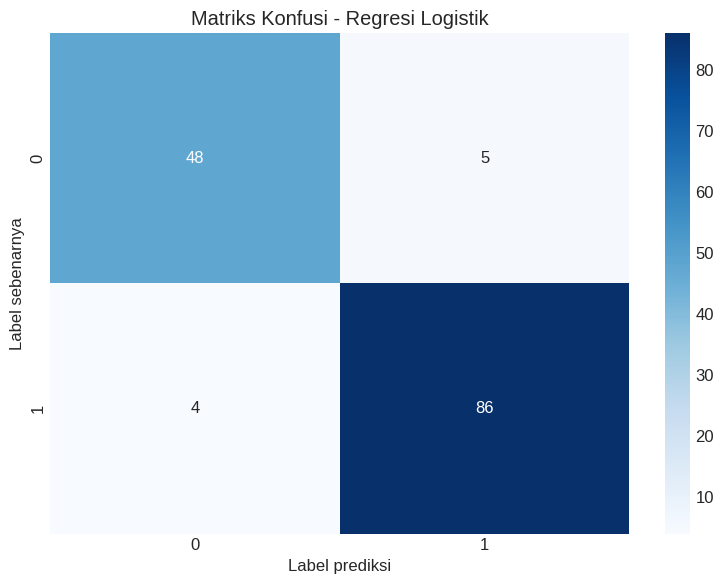

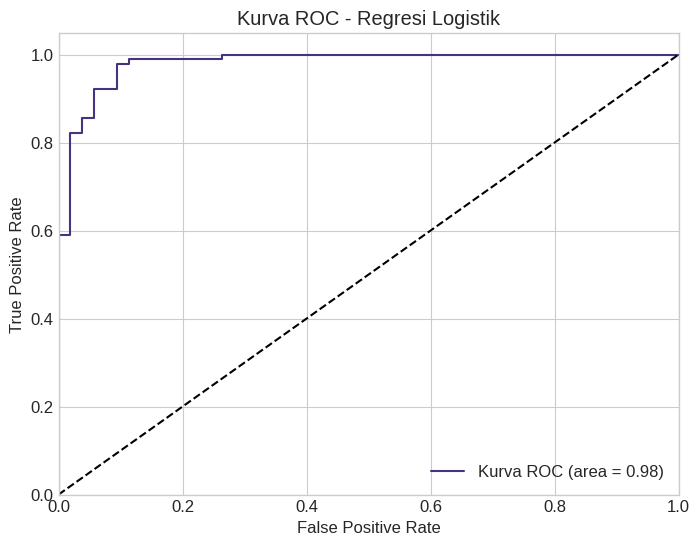


--------------------------------------------------
Melatih dan mengevaluasi: Decision Tree
--------------------------------------------------

Akurasi: 0.9091
Presisi: 0.9425
Recall: 0.9111
Skor F1: 0.9266
Waktu pelatihan: 0.07 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.86      0.91      0.88        53
           1       0.94      0.91      0.93        90

    accuracy                           0.91       143
   macro avg       0.90      0.91      0.90       143
weighted avg       0.91      0.91      0.91       143



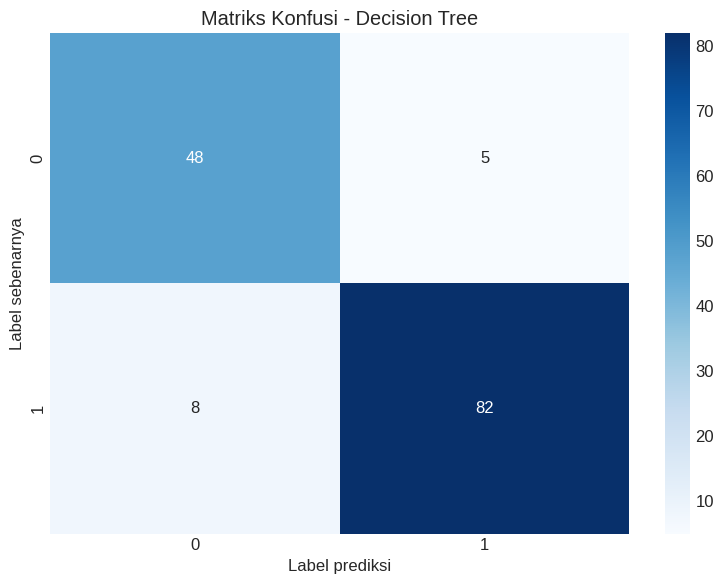

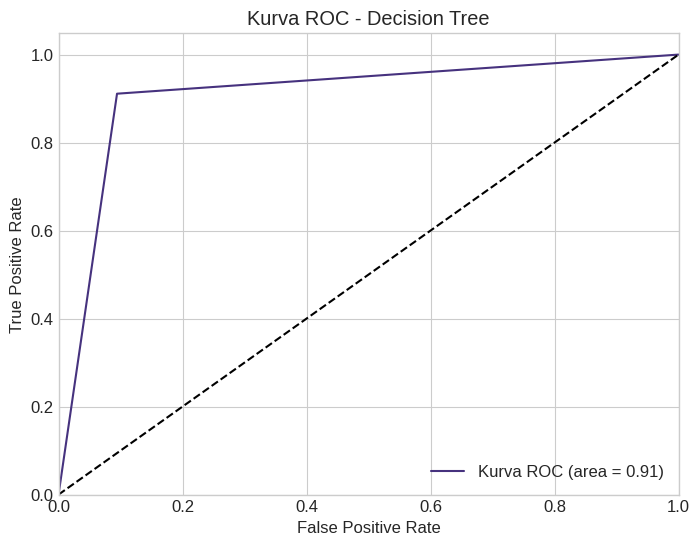


--------------------------------------------------
Melatih dan mengevaluasi: K-Nearest Neighbors
--------------------------------------------------

Akurasi: 0.9301
Presisi: 0.9348
Recall: 0.9556
Skor F1: 0.9451
Waktu pelatihan: 0.05 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        53
           1       0.93      0.96      0.95        90

    accuracy                           0.93       143
   macro avg       0.93      0.92      0.92       143
weighted avg       0.93      0.93      0.93       143



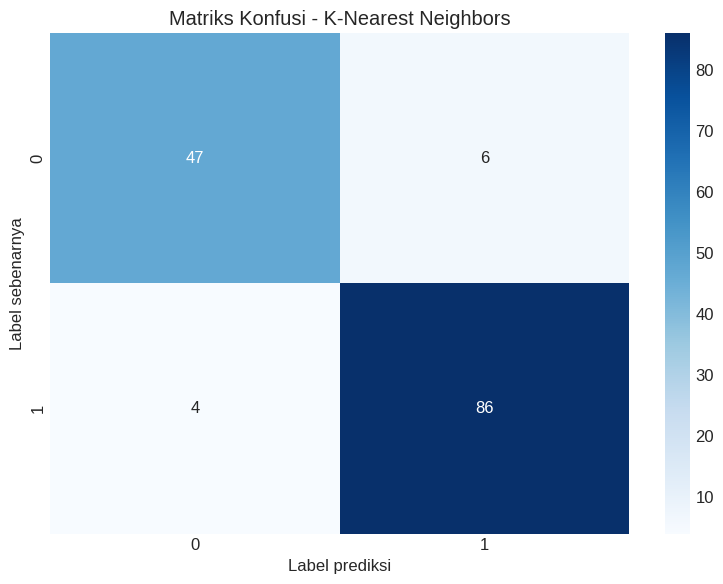

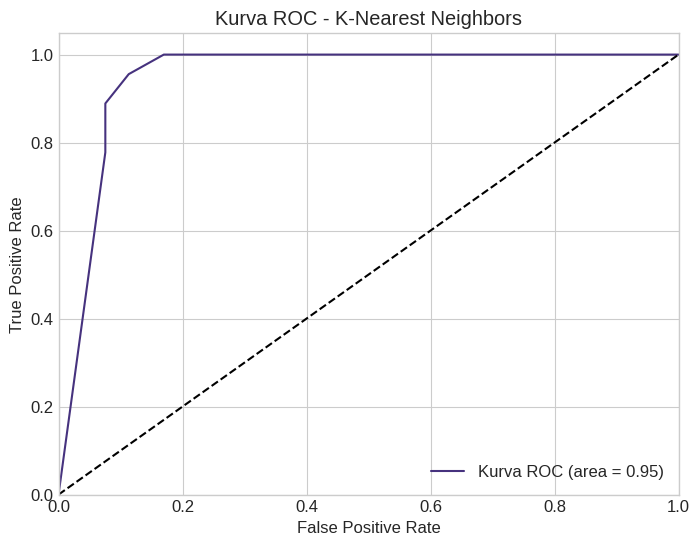


--------------------------------------------------
Melatih dan mengevaluasi: Support Vector Machine
--------------------------------------------------

Akurasi: 0.9301
Presisi: 0.9444
Recall: 0.9444
Skor F1: 0.9444
Waktu pelatihan: 0.05 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        53
           1       0.94      0.94      0.94        90

    accuracy                           0.93       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143



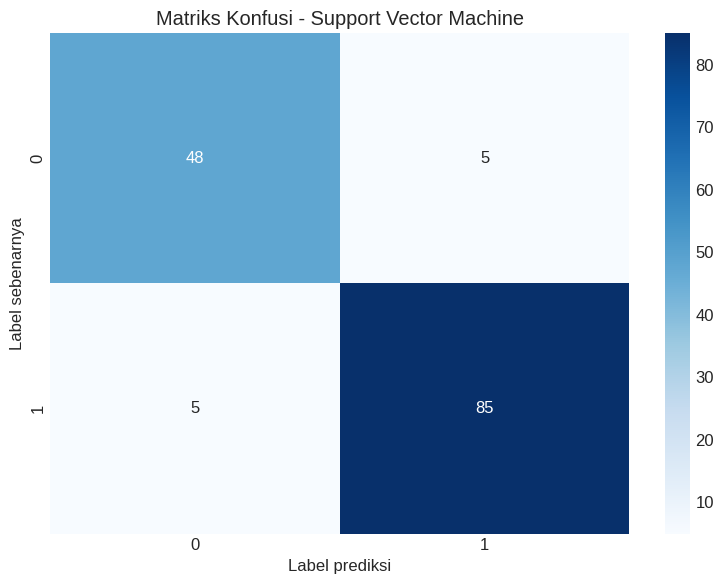

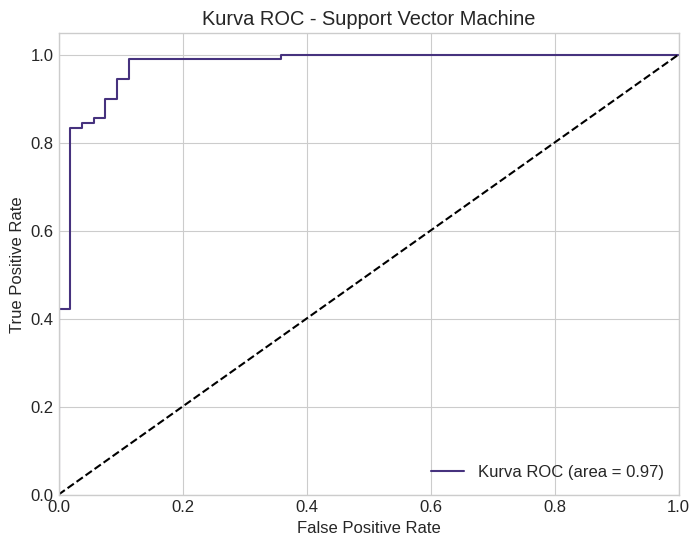


--------------------------------------------------
Melatih dan mengevaluasi: Random Forest
--------------------------------------------------

Akurasi: 0.9301
Presisi: 0.9348
Recall: 0.9556
Skor F1: 0.9451
Waktu pelatihan: 0.64 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90        53
           1       0.93      0.96      0.95        90

    accuracy                           0.93       143
   macro avg       0.93      0.92      0.92       143
weighted avg       0.93      0.93      0.93       143



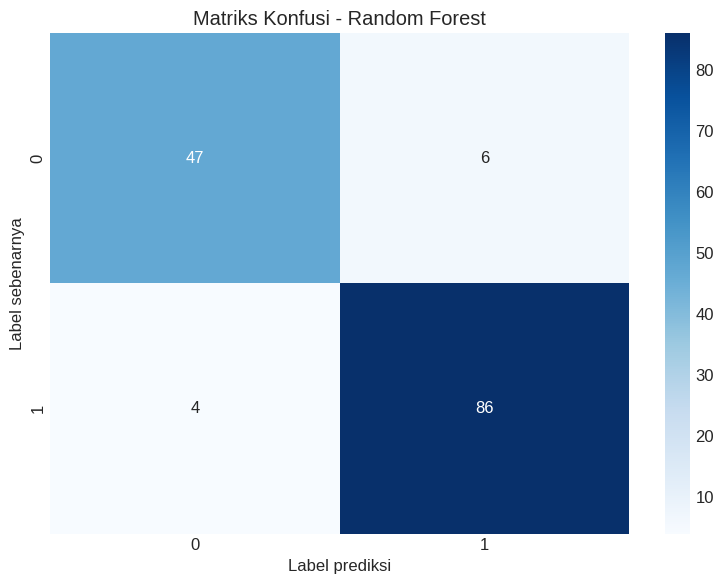

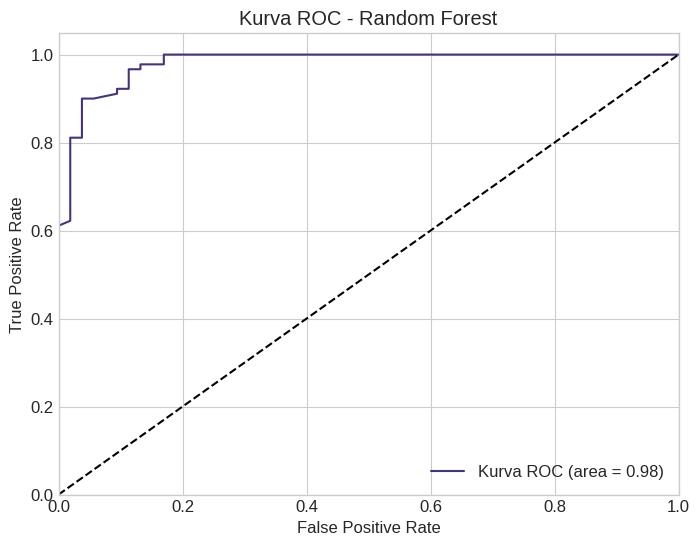


--------------------------------------------------
Melatih dan mengevaluasi: AdaBoost
--------------------------------------------------

Akurasi: 0.9091
Presisi: 0.9326
Recall: 0.9222
Skor F1: 0.9274
Waktu pelatihan: 0.27 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88        53
           1       0.93      0.92      0.93        90

    accuracy                           0.91       143
   macro avg       0.90      0.90      0.90       143
weighted avg       0.91      0.91      0.91       143



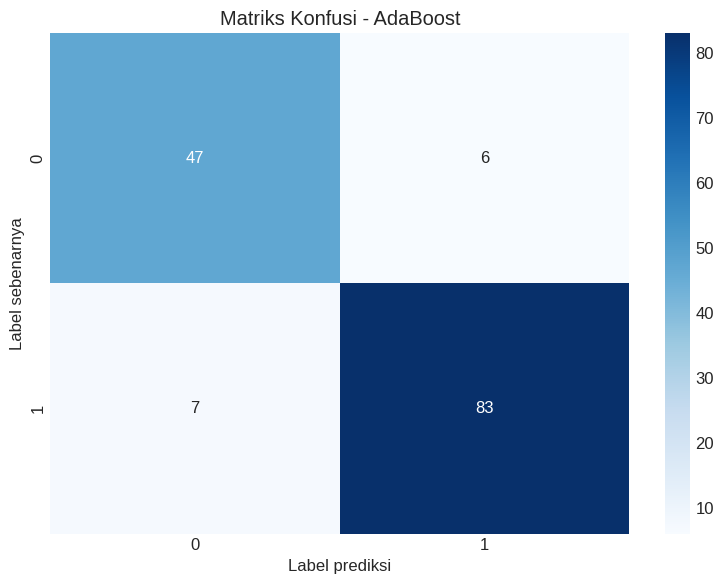

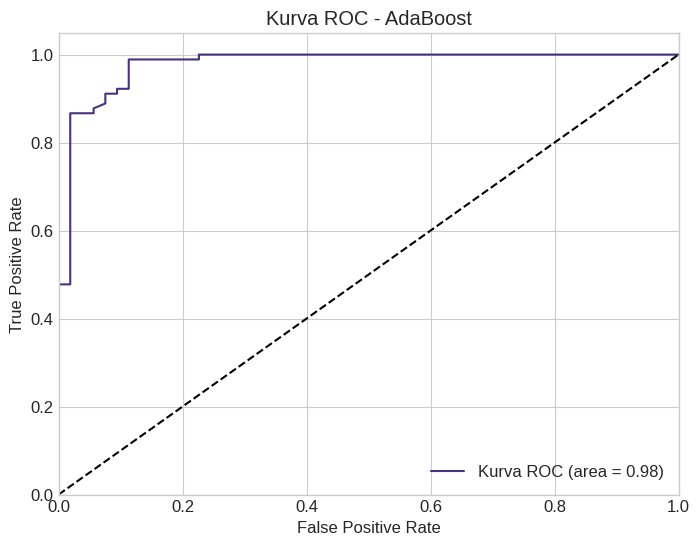


--------------------------------------------------
Melatih dan mengevaluasi: Gradient Boosting
--------------------------------------------------

Akurasi: 0.9161
Presisi: 0.9333
Recall: 0.9333
Skor F1: 0.9333
Waktu pelatihan: 0.47 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        53
           1       0.93      0.93      0.93        90

    accuracy                           0.92       143
   macro avg       0.91      0.91      0.91       143
weighted avg       0.92      0.92      0.92       143



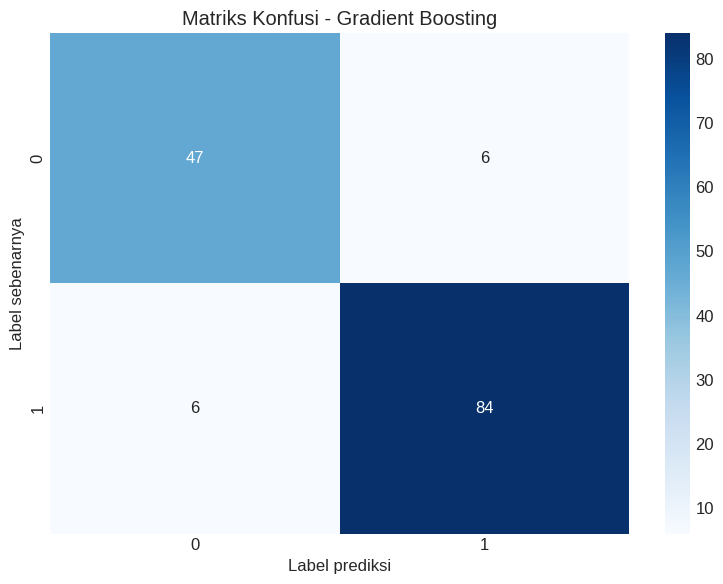

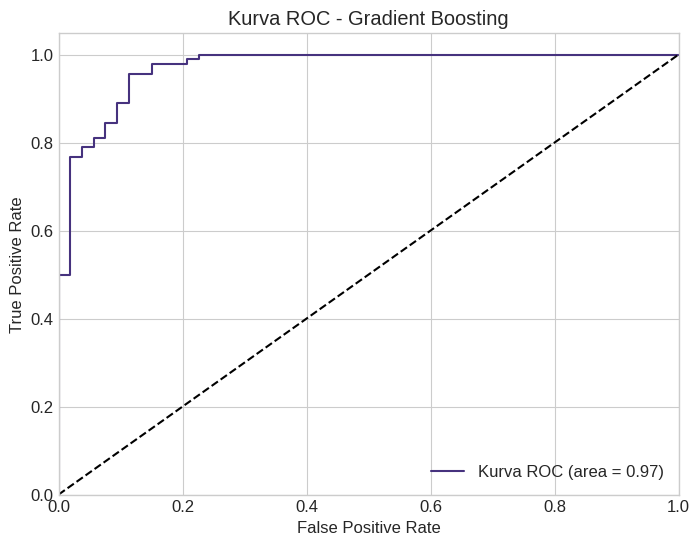


--------------------------------------------------
Melatih dan mengevaluasi: Bagging Classifier
--------------------------------------------------

Akurasi: 0.8881
Presisi: 0.9405
Recall: 0.8778
Skor F1: 0.9080
Waktu pelatihan: 0.08 detik

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86        53
           1       0.94      0.88      0.91        90

    accuracy                           0.89       143
   macro avg       0.88      0.89      0.88       143
weighted avg       0.89      0.89      0.89       143



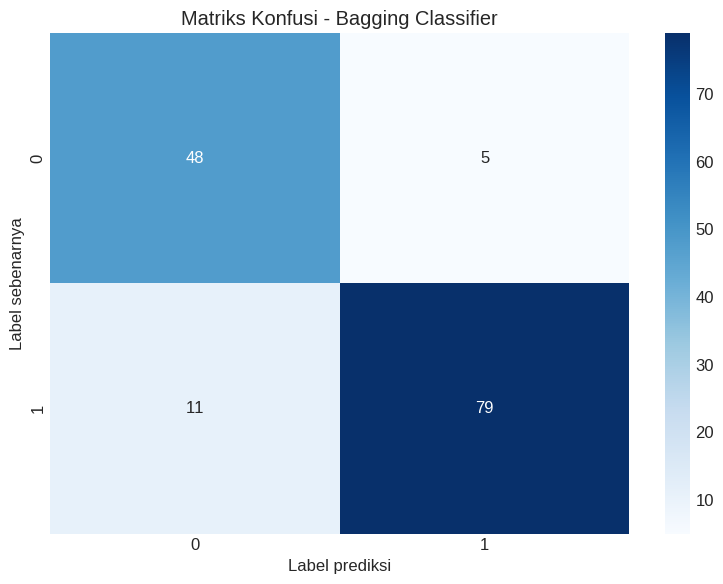

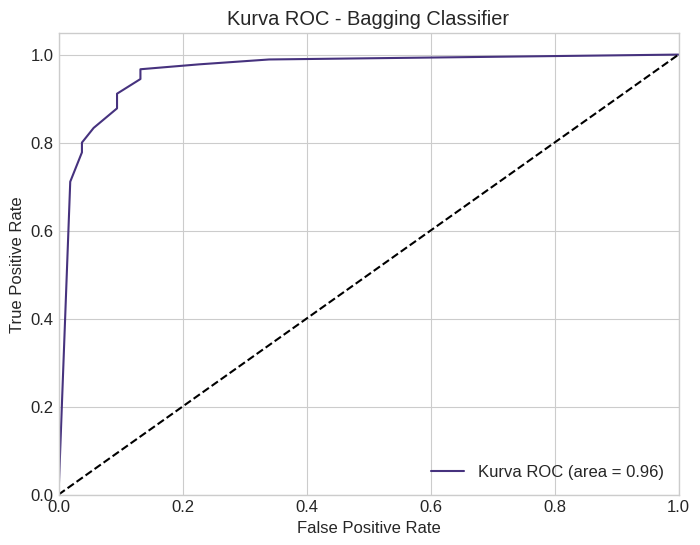

In [12]:
print("\n" + "="*80)
print("LANGKAH 4: PELATIHAN MODEL DAN EVALUASI")
print("="*80)

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(
    X_engineered, y, test_size=0.25, random_state=42, stratify=y)

print(f"Set pelatihan: {X_train.shape[0]} sampel")
print(f"Set pengujian: {X_test.shape[0]} sampel")

# Mendefinisikan model yang akan dievaluasi
models = {
    'Regresi Logistik': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Support Vector Machine': SVC(probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'AdaBoost': AdaBoostClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'Bagging Classifier': BaggingClassifier(random_state=42)
}

# Menyiapkan penyimpanan hasil
results = []
model_predictions = {}
model_probabilities = {}
trained_models = {}

# Memeriksa apakah klasifikasi biner atau multi-kelas
n_classes = len(np.unique(y))
is_binary = (n_classes == 2)
print(f"\nTipe klasifikasi: {'Biner' if is_binary else 'Multi-kelas'} ({n_classes} kelas)")

# Melatih dan mengevaluasi setiap model
for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Melatih dan mengevaluasi: {name}")
    print(f"{'-'*50}")

    start_time = time.time()

    # Melatih model
    model.fit(X_train, y_train)

    # Menyimpan model terlatih
    trained_models[name] = model

    # Membuat prediksi
    y_pred = model.predict(X_test)
    model_predictions[name] = y_pred

    # Mendapatkan probabilitas jika tersedia
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)
        model_probabilities[name] = y_prob
    else:
        model_probabilities[name] = None
        print(f"Catatan: {name} tidak mendukung prediksi probabilitas")

    # Menghitung metrik
    accuracy = accuracy_score(y_test, y_pred)

    if is_binary:
        precision = precision_score(y_test, y_pred, average='binary')
        recall = recall_score(y_test, y_pred, average='binary')
        f1 = f1_score(y_test, y_pred, average='binary')
    else:
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

    # Menyimpan hasil
    results.append({
        'Model': name,
        'Akurasi': accuracy,
        'Presisi': precision,
        'Recall': recall,
        'Skor F1': f1,
        'Waktu Pelatihan': time.time() - start_time
    })

    # Mencetak hasil dasar
    print(f"\nAkurasi: {accuracy:.4f}")
    print(f"Presisi: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Skor F1: {f1:.4f}")
    print(f"Waktu pelatihan: {time.time() - start_time:.2f} detik")

    # Mencetak laporan klasifikasi
    print("\nLaporan Klasifikasi:")
    print(classification_report(y_test, y_pred))

    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=np.unique(y),
               yticklabels=np.unique(y))
    plt.title(f'Matriks Konfusi - {name}')
    plt.ylabel('Label sebenarnya')
    plt.xlabel('Label prediksi')
    plt.tight_layout()
    plt.show()

    # Plot kurva ROC untuk klasifikasi biner
    if is_binary and model_probabilities[name] is not None:
        # Kurva ROC
        fpr, tpr, _ = roc_curve(y_test, model_probabilities[name][:, 1])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'Kurva ROC (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Kurva ROC - {name}')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

### Perbandingan dan Analisis Model

Terakhir, kita akan membandingkan semua model dan menganalisis model terbaik secara detail.


PERBANDINGAN MODEL

Metrik Performa untuk Semua Model:
                    Model   Akurasi   Presisi    Recall   Skor F1  \
0        Regresi Logistik  0.937063  0.945055  0.955556  0.950276   
1     K-Nearest Neighbors  0.930070  0.934783  0.955556  0.945055   
2           Random Forest  0.930070  0.934783  0.955556  0.945055   
3  Support Vector Machine  0.930070  0.944444  0.944444  0.944444   
4       Gradient Boosting  0.916084  0.933333  0.933333  0.933333   
5                AdaBoost  0.909091  0.932584  0.922222  0.927374   
6           Decision Tree  0.909091  0.942529  0.911111  0.926554   
7      Bagging Classifier  0.888112  0.940476  0.877778  0.908046   

   Waktu Pelatihan  
0         0.183715  
1         0.052867  
2         0.644002  
3         0.054707  
4         0.469265  
5         0.272989  
6         0.070176  
7         0.079497  


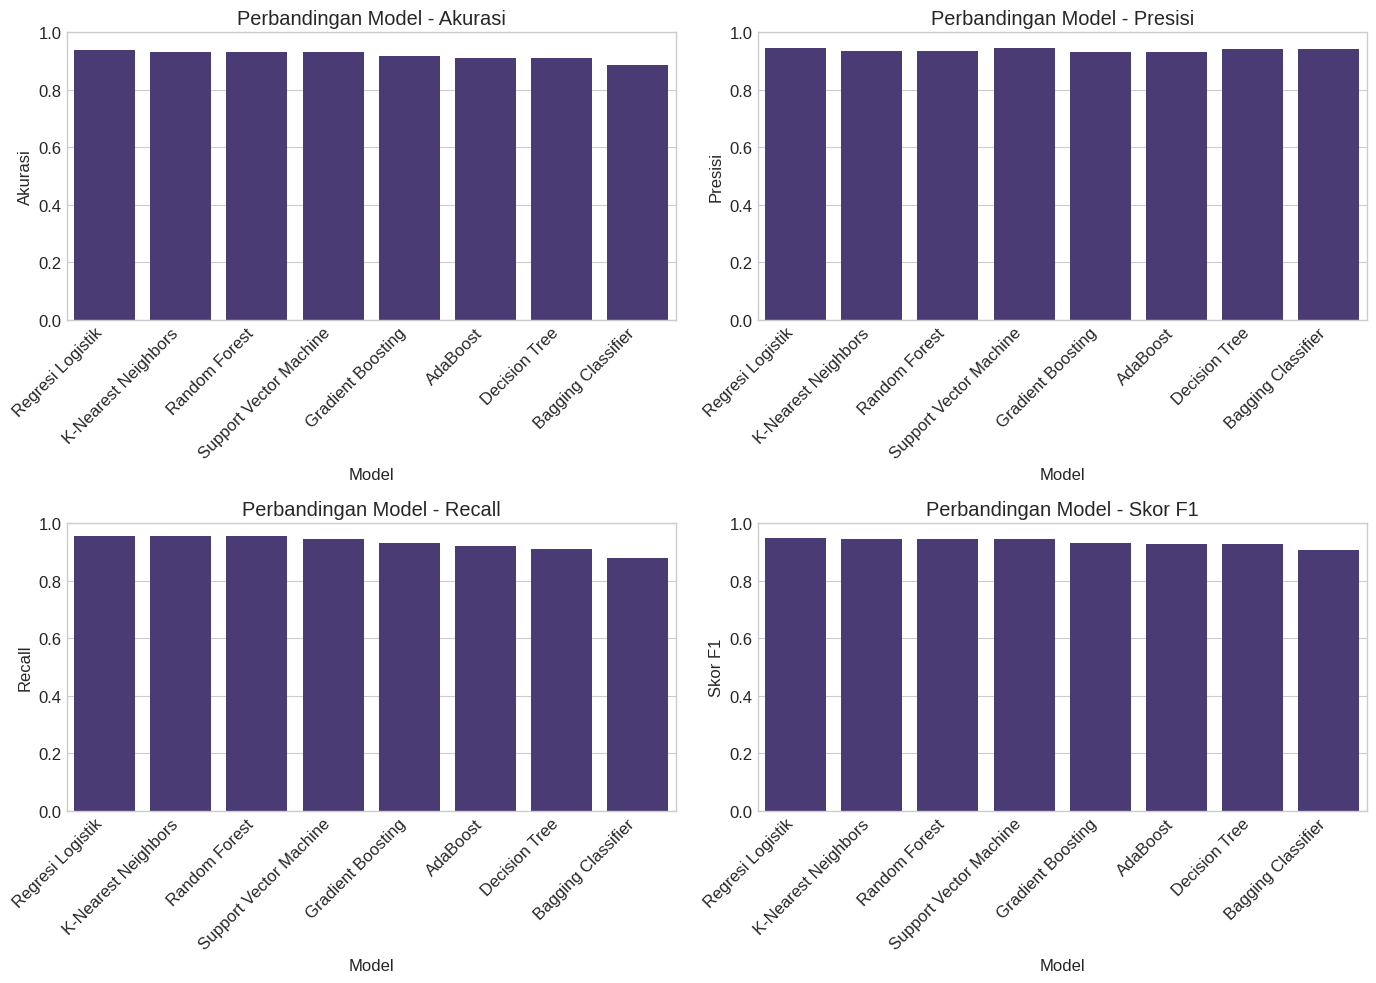

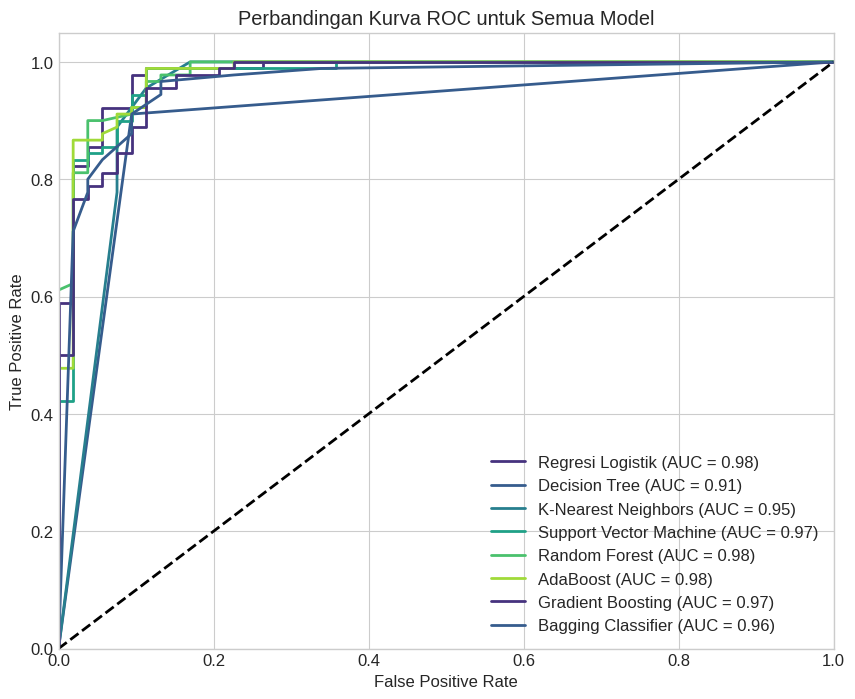


Model terbaik berdasarkan Skor F1: Regresi Logistik dengan skor 0.9503

--------------------------------------------------
Analisis Kepentingan Fitur untuk Model Terbaik: Regresi Logistik
--------------------------------------------------

Koefisien Regresi Logistik:
               Fitur  Koefisien  Koefisien Abs
0        mean radius  -2.450842       2.450842
4  worst compactness  -1.757510       1.757510
2       radius error  -1.298227       1.298227
1       mean texture  -1.078158       1.078158
3      texture error   0.464493       0.464493


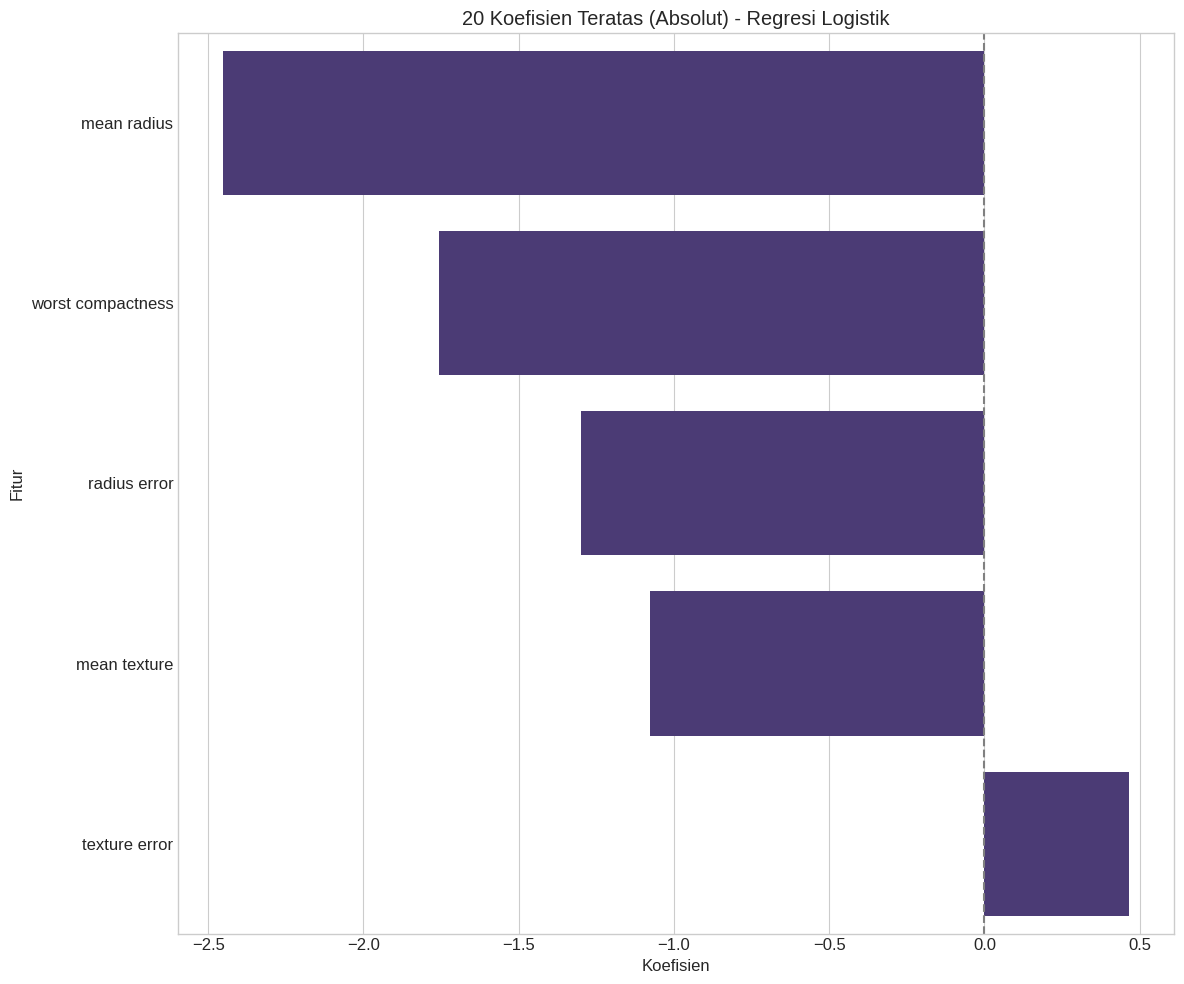

In [13]:
# Mengkonversi hasil ke DataFrame
results_df = pd.DataFrame(results)

# Mengurutkan berdasarkan Skor F1 (menurun)
results_df = results_df.sort_values('Skor F1', ascending=False).reset_index(drop=True)

print("\n" + "="*50)
print("PERBANDINGAN MODEL")
print("="*50)
print("\nMetrik Performa untuk Semua Model:")
print(results_df)

# Visualisasi perbandingan model
plt.figure(figsize=(14, 10))

# Plot perbandingan metrik
metrics = ['Akurasi', 'Presisi', 'Recall', 'Skor F1']
for i, metric in enumerate(metrics):
    plt.subplot(2, 2, i+1)
    sns.barplot(x='Model', y=metric, data=results_df)
    plt.title(f'Perbandingan Model - {metric}')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 1)

plt.tight_layout()
plt.show()
# Perbandingan kurva ROC untuk klasifikasi biner
if is_binary:
    plt.figure(figsize=(10, 8))

    for name, model in trained_models.items():
        if model_probabilities[name] is not None:
            fpr, tpr, _ = roc_curve(y_test, model_probabilities[name][:, 1])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Perbandingan Kurva ROC untuk Semua Model')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# Identifikasi model terbaik
best_model_name = results_df.iloc[0]['Model']
best_model = trained_models[best_model_name]
best_f1 = results_df.iloc[0]['Skor F1']

print(f"\nModel terbaik berdasarkan Skor F1: {best_model_name} dengan skor {best_f1:.4f}")

# Feature importance untuk model terbaik (jika tersedia)
print("\n" + "-"*50)
print(f"Analisis Kepentingan Fitur untuk Model Terbaik: {best_model_name}")
print("-"*50)

if hasattr(best_model, 'feature_importances_'):
    # Dapatkan kepentingan fitur
    importances = best_model.feature_importances_
    feature_names = X_engineered.columns

    # Buat DataFrame untuk tampilan yang lebih baik
    importance_df = pd.DataFrame({
        'Fitur': feature_names,
        'Kepentingan': importances
    }).sort_values('Kepentingan', ascending=False)

    print("\nKepentingan Fitur untuk Model Terbaik:")
    print(importance_df.head(20))  # Tampilkan 20 fitur teratas

    # Visualisasi kepentingan fitur
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Kepentingan', y='Fitur', data=importance_df.head(20))
    plt.title(f'20 Fitur Teratas - {best_model_name}')
    plt.tight_layout()
    plt.show()

elif best_model_name == 'Regresi Logistik':
    # Untuk Regresi Logistik, kita bisa menggunakan koefisien
    if is_binary:
        coefficients = best_model.coef_[0]
        feature_names = X_engineered.columns

        # Buat DataFrame dengan nilai absolut koefisien
        coef_df = pd.DataFrame({
            'Fitur': feature_names,
            'Koefisien': coefficients,
            'Koefisien Abs': np.abs(coefficients)
        }).sort_values('Koefisien Abs', ascending=False)

        print("\nKoefisien Regresi Logistik:")
        print(coef_df.head(20))

        # Visualisasi koefisien
        plt.figure(figsize=(12, 10))
        sns.barplot(x='Koefisien', y='Fitur', data=coef_df.head(20))
        plt.title('20 Koefisien Teratas (Absolut) - Regresi Logistik')
        plt.axvline(x=0, color='gray', linestyle='--')
        plt.tight_layout()
        plt.show()
    else:
        print("Visualisasi koefisien untuk Regresi Logistik multi-kelas tidak ditampilkan.")
else:
    print(f"Model {best_model_name} tidak menyediakan informasi kepentingan fitur secara langsung.")

# Analisis Model Machine Learning: Evaluasi Metrik dan Strategi Optimasi

## 1. Ketidaksesuaian AUC-ROC Tinggi dan Presisi Rendah

Ketika model menunjukkan AUC-ROC tinggi (0.92) tetapi Presisi sangat rendah (15%), beberapa faktor penyebab utama ketidaksesuaian ini adalah:

**Penyebab Utama:**
- **Ketidakseimbangan kelas (class imbalance)**: Dataset kemungkinan memiliki distribusi kelas yang sangat tidak seimbang, dimana kelas positif jumlahnya jauh lebih sedikit. Model dapat mencapai AUC-ROC tinggi dengan memprediksi peluang dengan baik, namun threshold default 0.5 menghasilkan banyak false positive.
- **Threshold prediksi yang tidak optimal**: AUC-ROC mengukur performa pada semua kemungkinan threshold, sedangkan Presisi dihitung pada satu threshold tertentu (biasanya 0.5).
- **Distribusi probabilitas yang tidak dikalibrasi**: Model mungkin menghasilkan probabilitas yang tidak dikalibrasi dengan baik, meskipun peringkat relatifnya akurat.

**Strategi Tuning Hyperparameter:**
- **Mengubah threshold klasifikasi**: Menaikkan threshold untuk mengurangi false positive, sehingga meningkatkan Presisi tanpa banyak mempengaruhi AUC-ROC.
- **Class weight adjustment**: Memberikan bobot lebih pada kelas minoritas saat training untuk meningkatkan sensitivitas model terhadap kelas positif.
- **Regularisasi yang tepat**: Menggunakan regularisasi yang sesuai (seperti L1 atau L2) untuk mengurangi overfitting pada kelas mayoritas.
- **Focal Loss**: Menggunakan fungsi loss yang memberi perhatian lebih pada sampel yang sulit diklasifikasikan.

**Pentingnya Recall:**
- Recall menjadi pertimbangan kritis karena mengukur kemampuan model untuk mendeteksi semua kasus positif (true positive rate).
- Hubungan dengan cost false negative sangat signifikan - dalam kasus seperti fraud detection atau diagnosis medis, melewatkan kasus positif (false negative) seringkali memiliki konsekuensi lebih berat dibandingkan false positive.
- Trade-off antara Presisi dan Recall perlu disesuaikan berdasarkan biaya relatif dari false positive vs false negative dalam konteks bisnis spesifik.

## 2. Dampak Fitur Kategorikal High-Cardinality

Fitur kategorikal dengan 1000 nilai unik (high-cardinality) memiliki dampak signifikan terhadap model:

**Dampak terhadap Estimasi Koefisien dan Stabilitas Presisi:**
- **Curse of Dimensionality**: One-hot encoding akan menciptakan 1000 fitur baru, meningkatkan dimensi secara drastis yang menyebabkan sparsitas data.
- **Ketidakstabilan Koefisien**: Banyak kategori dengan sampel terbatas menghasilkan estimasi koefisien yang tidak stabil dan varians tinggi.
- **Overfitting**: Model cenderung overfit pada kategori-kategori langka yang mungkin hanya muncul beberapa kali dalam dataset.
- **Presisi yang tidak stabil**: Sampel test mungkin memiliki distribusi kategori berbeda dari training, menyebabkan presisi berfluktuasi.

**Risiko Target Encoding:**
- Target encoding berisiko menyebabkan data leakage karena secara langsung menginkorporasikan informasi target ke dalam fitur.
- Dalam cross-validation, jika target encoding tidak dilakukan secara proper dalam setiap fold, informasi dari validation set bisa "bocor" ke training set.
- Kategori langka cenderung mendapatkan encoding ekstrem yang dapat menyebabkan overfitting.

**Alternatif Encoding yang Lebih Aman:**
- **Feature Hashing**: Memetakan kategori ke sejumlah bucket terbatas, mengurangi dimensi tanpa memerlukan informasi target.
- **Binary Encoding**: Mengubah kategori menjadi representasi biner, menghasilkan jumlah fitur yang jauh lebih sedikit (~log2(1000) = 10 fitur).
- **Embedding Learning**: Menggunakan teknik neural network untuk mempelajari representasi kategori dalam ruang dimensi rendah.
- **Hierarchical Clustering**: Mengelompokkan kategori berdasarkan kesamaan properti untuk mengurangi kardinalitas.
- **Cross-validated Target Encoding**: Jika target encoding diperlukan, lakukan dengan proper cross-validation untuk mencegah data leakage.

## 3. Dampak Normalisasi Min-Max terhadap Model SVM dan Gradient Boosting

Setelah normalisasi Min-Max, model SVM linear mengalami peningkatan Presisi dari 40% ke 60% tetapi Recall turun 20%:

**Analisis Dampak terhadap Decision Boundary dan Margin:**
- **Penskalaan Fitur**: Normalisasi Min-Max mengubah skala semua fitur ke range [0,1], yang sangat mempengaruhi SVM yang sensitif terhadap skala.
- **Perubahan Decision Boundary**: Normalisasi menyebabkan pergeseran decision boundary SVM, mengubah trade-off antara Presisi dan Recall.
- **Efek pada Margin Kelas Minoritas**: Normalisasi mungkin menyebabkan margin di sekitar sampel kelas minoritas menyempit, membuat beberapa sampel positif yang sebelumnya terklasifikasi benar menjadi false negative.
- **Perubahan Geometri Data**: Normalisasi mengubah jarak relatif antar titik data, yang sangat mempengaruhi pembuatan hyperplane optimal SVM.

**Efek Berbeda pada Gradient Boosting:**
- Gradient Boosting kurang sensitif terhadap penskalaan fitur karena berbasis decision tree yang secara alami invariant terhadap transformasi monoton.
- Pada Gradient Boosting, normalisasi Min-Max mungkin memiliki dampak minimal atau bahkan berlawanan karena:
  - Decision tree membuat split berdasarkan peringkat relatif nilai fitur, bukan nilai absolutnya.
  - Penskalaan tidak mengubah urutan atau peringkat data.
  - Gradient Boosting lebih fokus pada pola nonlinear yang tidak terpengaruh oleh transformasi linear.
- Jika terjadi perbedaan performa, kemungkinan disebabkan oleh faktor kebetulan atau interaksi dengan hyperparameter lain seperti learning rate.

## 4. Mekanisme Matematis Feature Interaction

Eksperimen feature interaction dengan menggabungkan dua fitur melalui perkalian meningkatkan AUC-ROC dari 0.75 ke 0.82:

**Mekanisme Matematis:**
- **Transformasi Nonlinear**: Perkalian dua fitur menciptakan transformasi nonlinear yang mengubah geometri ruang fitur.
- **Ekspansi Dimensi**: Interaksi fitur memungkinkan model linier untuk memodelkan hubungan nonlinier tanpa mengubah struktur model.
- **Perubahan Decision Boundary**: Dalam ruang fitur asli, decision boundary yang sebelumnya hanya bisa linear (dengan model linear) kini dapat menjadi kurva nonlinear berkat fitur interaksi.
- **Matematika Interaksi**: Jika model sebelumnya adalah `f(x) = w₁x₁ + w₂x₂ + b`, dengan interaksi menjadi `f(x) = w₁x₁ + w₂x₂ + w₃(x₁×x₂) + b`, memungkinkan model menangkap efek saat fitur x₁ dan x₂ bekerja bersama.

**Kegagalan Uji Statistik:**
- Chi-square dan uji statistik univariat serupa gagal mendeteksi interaksi karena:
  - Uji ini hanya melihat hubungan antara satu fitur dan target, tidak antar fitur.
  - Interaksi kompleks sulit terdeteksi dengan pengujian independensi sederhana.
  - Meskipun fitur individual mungkin memiliki korelasi lemah dengan target, kombinasinya bisa sangat prediktif.

**Metode Domain Knowledge Alternatif:**
- **Exploratory Data Analysis (EDA)**: Visualisasi multidimensi seperti partial dependence plots atau heatmap.
- **Feature Engineering berdasarkan Domain**: Memanfaatkan pengetahuan ahli untuk mengidentifikasi potensi interaksi bermakna.
- **Metode Deteksi Interaksi**: Teknik seperti H-statistic atau Individual Conditional Expectation (ICE) plots.
- **Regularized Interaction Models**: MARS (Multivariate Adaptive Regression Splines) yang secara otomatis menemukan interaksi penting.
- **Neural Network dengan Hidden Layers**: Secara implisit memodelkan interaksi kompleks tanpa spesifikasi eksplisit.

## 5. Data Leakage dari Oversampling dan Strategi Preprocessing

Penggunaan oversampling sebelum pembagian train-test menyebabkan data leakage dengan AUC-ROC validasi 0.95 tetapi AUC-ROC testing 0.65:

**Mengapa Temporal Split Lebih Aman untuk Fraud Detection:**
- **Pola Temporal**: Fraud detection biasanya melibatkan pola yang berubah seiring waktu (concept drift), seperti penipuan yang beradaptasi terhadap sistem deteksi.
- **Realisme Evaluasi**: Temporal split (membagi data berdasarkan waktu) mensimulasikan skenario dunia nyata dimana model dilatih pada data lama untuk memprediksi kasus baru.
- **Mencegah Data Leakage**: Dengan temporal split, tidak ada informasi masa depan yang bisa bocor ke dalam data training.
- **Deteksi Concept Drift**: Temporal split memungkinkan pengukuran degradasi performa model seiring waktu, informasi kritis untuk fraud detection.

**Bagaimana Stratified Sampling Dapat Memperparah Masalah:**
- Stratified sampling memastikan distribusi kelas yang sama antara train dan test, namun dalam kasus fraud:
  - Dapat secara tidak sengaja mengelompokkan fraud yang terkait (misalnya dari kampanye penipuan yang sama) di kedua set.
  - Mengabaikan dimensi temporal dari pola fraud yang berevolusi.
  - Memberikan estimasi performa terlalu optimis yang tidak mencerminkan realitas.

**Desain Preprocessing yang Benar:**
- **Urutan yang Tepat**: Pertama pisahkan data menjadi train-test-validation, kemudian lakukan oversampling HANYA pada training set.
- **Cross-Validation Temporal**: Gunakan time-based cross-validation seperti "sliding window" atau "expanding window".
- **Penanganan Imbalance yang Tepat**:
  - SMOTE atau oversampling sintetis lainnya hanya pada training set.
  - Gunakan teknik undersampling yang mempertimbangkan distribusi kelas minoritas.
  - Cost-sensitive learning sebagai alternatif oversampling.
- **Monitoring Distribution Shift**: Implementasikan mekanisme untuk mendeteksi perubahan distribusi antara training dan produksi.
- **Evaluasi Realistis**: Gunakan metrik yang relevan dengan distribusi kelas imbalance (F1-score, AUPRC) bukan hanya AUC-ROC.
- **Threshold Optimization**: Kalibrasi threshold prediksi berdasarkan biaya bisnis spesifik untuk false positive vs false negative.